In [37]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np
from torchvision import utils, transforms, datasets


In [38]:
torch.cuda.is_available()

True

In [39]:
class TrafficSignsDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None, target_transform=None):
        """
        Arguments:
            annotations_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations_file = pd.read_csv(annotations_file)
        self.img_labels = self.annotations_file['ClassId']
        self.img_path = self.annotations_file['Path']
        self.img_width = self.annotations_file['Width']
        self.img_height = self.annotations_file['Height']
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_path.iloc[idx])
        image = io.imread(img_path)
        label = self.img_labels.iloc[idx]
        img_width = self.img_width.iloc[idx]
        img_height = self.img_height.iloc[idx]

        sample = {'image': image, 'label': label, 'img_width': img_width, 'img_height': img_height}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_classes(self):
        return self.img_labels.unique()

In [40]:
class ConvertPIL(object):
    def __init__(self):
        self.pil_image = transforms.ToPILImage()

    def __call__(self, sample):
        image = sample['image']
        image = self.pil_image(image)
        return {'image': image, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        # h, w = image.shape[:2]
        h, w = image.size

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        resize = transforms.Resize((new_h, new_w))
        img = resize(image)
        return {'image': img, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}
    
class RandHorizFlip(object):
    def __init__(self, p):
        self.horiz_flip = transforms.RandomHorizontalFlip(p=p)

    def __call__(self, sample):
        image = sample['image']
        image = self.horiz_flip(image)
        return {'image': image, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}

class RandVertFlip(object):
    def __init__(self, p):
        self.vert_flip = transforms.RandomVerticalFlip(p=p)

    def __call__(self, sample):
        image = sample['image']
        image = self.vert_flip(image)
        return {'image': image, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}

class RandCrop(object):
     def __init__(self, size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)):
        self.crop = transforms.RandomResizedCrop(size=size, scale=scale, ratio=ratio)
        
     def __call__(self, sample):
        image = sample['image']
        image = self.crop(image)
        return {'image': image, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        self.to_tensor = transforms.ToTensor()

    def __call__(self, sample):
        image = sample['image']
        image = self.to_tensor(image)
        # print(image.shape)
        return {'image': image, 'label': sample['label'], 'img_width': sample['img_width'], 'img_height': sample['img_height']}

In [41]:
data_transform = transforms.Compose([
        ConvertPIL(),
        Rescale((32, 32)),
        RandCrop(32),
        RandHorizFlip(0.5),
        RandVertFlip(0.5),
        ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

In [42]:
train_traffic_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Train.csv', 
                                      root_dir='../../dataset/GTSRB',
                                      transform=data_transform)

for i, sample in enumerate(train_traffic_dataset):
    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 32, 32]) 20
1 torch.Size([3, 32, 32]) 20
2 torch.Size([3, 32, 32]) 20
3 torch.Size([3, 32, 32]) 20


In [43]:
train_dataset_length = len(train_traffic_dataset)
print(train_dataset_length)

39209


In [44]:
train_dataset_loader = torch.utils.data.DataLoader(train_traffic_dataset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=4)

In [45]:
def show_traffic_signs(sample_batched):
    """Show traffic signs for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

0 torch.Size([64, 3, 32, 32])
1 torch.Size([64, 3, 32, 32])
2 torch.Size([64, 3, 32, 32])
3 torch.Size([64, 3, 32, 32])
4 torch.Size([64, 3, 32, 32])


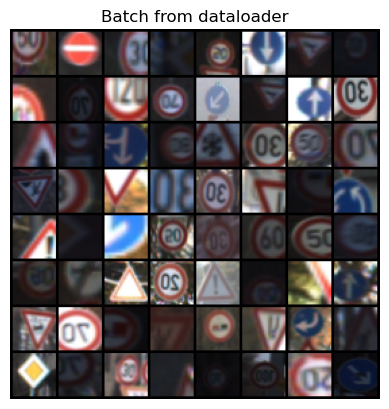

In [46]:
for i_batch, sample_batched in enumerate(train_dataset_loader):
    print(i_batch, sample_batched['image'].size())
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([4, 3, 32, 32]) tensor([17, 38, 10, 10])
1 torch.Size([4, 3, 32, 32]) tensor([35, 17, 10,  4])
2 torch.Size([4, 3, 32, 32]) tensor([ 1, 25,  5,  9])
3 torch.Size([4, 3, 32, 32]) tensor([ 2, 10, 12,  4])
4 torch.Size([4, 3, 32, 32]) tensor([ 3, 18, 35, 25])


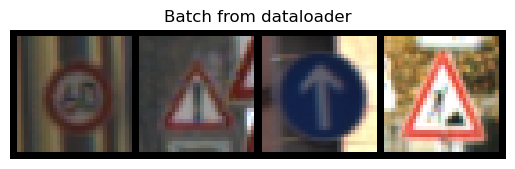

In [47]:
test_traffic_dataset = TrafficSignsDataset(annotations_file='../../dataset/GTSRB/Test.csv', 
                                           root_dir='../../dataset/GTSRB', transform=
                                           transforms.Compose([
                                            ConvertPIL(),
                                            Rescale((32, 32)),
                                            ToTensor()
                                        ]))

test_dataset_loader = torch.utils.data.DataLoader(test_traffic_dataset,
                                                batch_size=4,
                                                shuffle=True,
                                                num_workers=0)

for i_batch, sample_batched in enumerate(test_dataset_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_traffic_signs(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [48]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = len(train_traffic_dataset.get_classes())
print(num_classes)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

43


In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)

In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
EPOCHS = 2

In [ ]:
# Implement validation 
# Save loss, mean loss, training loss, validation loss
# Increase the number of layers of the model

In [52]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataset_loader):
        inputs = data['image']
        labels = data['label']

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 3.274
[1,   400] loss: 2.989
[1,   600] loss: 2.860
[2,   200] loss: 2.730
[2,   400] loss: 2.665
[2,   600] loss: 2.644
Finished Training
